# Basic usage of the se2cnn library

This jupyter demo will contain the basic usage examples of the se2cnn library with applications to digit recognition in the MNIST dataset. The se2cnn library contains 3 main layers (check the useage via *help(se2cnn.layers.z2_se2n)*):
- **z2_se2n**: a lifting layer from 2D tensor to SE(2) tensor
- **se2n_se2n**: a group convolution layer from SE(2) tensor to SE(2) tensor
- **spatial_max_pool**: performs 2x2 spatial max-pooling of the spatial axes

The following functions are used internally, but may be of interest as well:
- **rotate_lifting_kernels**: rotates the raw 2D lifting kernels (output is a set of rotated kernels)
- **rotate_gconv_kernels**: rotates (shift-twists) the se2 kernels (planar rotation + orientation shift)



In this demo we will construct the following network:

| layer nr. | Layer                          | Tensor shape  |
| --------- | ------------------------------ | ------------- |
| 0         | input                          | (32 x 32 x 1) |
| --------- | --------------------------------------------------- | -------------------------- |
| 1         | 5x5 lifting convultion (+ReLU) | (28 x 28 x Ntheta x Nc)  |
| 1         | 2x2 max pooling                | (14 x 14 x Ntheta x Nc)  |
| --------- | --------------------------------------------------- | -------------------------- |
| 2         | 5x5 group convultion (+ReLU)   | (10 x 10 x Ntheta x 2*Nc)  |
| 2         | 2x2 max pooling                | (5 x 5 x Ntheta x 2*Nc)  |
| --------- | --------------------------------------------------- | -------------------------- |
| 3         | merge orientation+channel dim  | (5 x 5 x Ntheta 2*Nc) |
| 3         | 5x5 2D convultion (+ReLU)      | (1 x 1 x 4*Nc)  |
| --------- | --------------------------------------------------- | -------------------------- |
| 4         | 1x1 2D convultion (+ReLU)      | (1 x 1 x 128)  |
| --------- | --------------------------------------------------- | -------------------------- |
| 5         | 1x1 2D convolution: the output layer | (10) |

Here Ntheta is the number of orientation samples to discretize the SE(2) group, Nc is the number of channels in the lifting layer. The first two layers are **roto-translation covariant**, meaning that the feature vectors rotate according to rotations of the input patterns (e.g. basic features do not need to be learned for each orientation). In layer 3 the orientation axis is merged with the channel axis, followed by 2D convolutions, making the subsequent layers **only translation covariant**. Here we made this choice due to the fact that in the MNIST dataset the characters always appear under the same orientation, and the task does not need to be rotation invariant.

There are several options to make a network completely roto-translation invariant:
1. For example one could stick with (5x5 and 1x1) SE(2) group convolutions all the way to the output layer, which would then provide a length 10 feature vector for each orientation. On can then simply do a maximum projection over the orientations (tf.reduce_max) to get the maximal response for each bin, followed by a softmax.
2. One coulde reduce the patch size to [1 x 1 x Ntheta x Nc] via group convolutions, apply a maximum projection over theta, and perform 1x1 (fully connected) 2D convolutions all the way to the end.

***
# Part 1: Load the libraries

## Load the libraries

In [1]:
# Impor tensorflow and numpy
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import math as m
import time
# For validation
from sklearn.metrics import confusion_matrix
import itertools



# For plotting
from matplotlib import pyplot as plt

# Add the library to the system path
import os,sys
se2cnn_source =  os.path.join(os.getcwd(),'..')
if se2cnn_source not in sys.path:
    sys.path.append(se2cnn_source)

# Import the library
import se2cnn.layers

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# check tf can see the GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6442215761500423407
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9848225792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4592071689028298819
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:06:00.0, compute capability: 8.9"
]


## Useful functions

### The se2cnn layers

For useage of the relevant layers defined in se2cnn.layers uncomment and run the following:

In [3]:
help(se2cnn.layers.z2_se2n)
help(se2cnn.layers.se2n_se2n)
help(se2cnn.layers.spatial_max_pool)

Help on function z2_se2n in module se2cnn.layers:

z2_se2n(input_tensor, kernel, orientations_nb, periodicity=6.283185307179586, diskMask=True, padding='VALID')
    Constructs a group convolutional layer.
    (lifting layer from Z2 to SE2N with N input number of orientations)
    
    INPUT:
        - input_tensor in Z2, a tensorflow Tensor with expected shape:
            [BatchSize, Height, Width, ChannelsIN]
        - kernel, a tensorflow Tensor with expected shape:
            [kernelSize, kernelSize, ChannelsIN, ChannelsOUT]
        - orientations_nb, an integer specifying the number of rotations
    
    INPUT (optional):
        - periodicity, rotate in total over 2*np.pi or np.pi
        - disk_mask, True or False, specifying whether or not to mask the kernels spatially
    
    OUTPUT:
        - output_tensor, the tensor after group convolutions with shape
            [BatchSize, Height', Width', orientations_nb, ChannelsOut]
            (Height', Width' are reduced sizes due 

### Weight initialization

For initialization we use the initialization method for ReLU activation functions as proposed in:

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

In [4]:
# Xavier's/He-Rang-Zhen-Sun initialization for layers that are followed ReLU
def weight_initializer(n_in, n_out):
    return tf.random_normal_initializer(mean=0.0, stddev=m.sqrt(2.0 / (n_in))
    )

### Size of a tf tensor

In [5]:
def size_of(tensor) :
    # Multiply elements one by one
    result = 1
    for x in tensor.get_shape().as_list():
         result = result * x 
    return result 

***
# Part 2: Load and format the MNIST dataset

The MNIS dataset consists of 28x28 images of handwritten characters. We are going to classify each input image into 1 of the 10 classes (the digits 0 to 9).

In [6]:
mnist = tf.keras.datasets.mnist
""" train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32) """

(train_data, train_labels), (eval_data, eval_labels) = mnist.load_data()




dataset = np.load('test_datasets/MC_data_28_10_70000.npy')

# 5x10 observation
# 1x50 label

non_test, test = np.split(dataset, [60000])

# first 50 is the observation, second 100 is the label
non_test_data = non_test[:, :28**2 *2]
non_test_labels= non_test[:, 28**2 *2:] # data shape here
test_data = test[:, :28**2 *2]
test_labels = test[:, 28**2 *2:]




By default the data is formatted as flattened arrays. Here were format them as 2D feature maps (with only 1 channel).

In [7]:
# Reshape to 2D multi-channel images
train_data_2D = train_data.reshape([len(train_data),28,28,1]) # [batch_size, Nx, Ny, Nc]
print(train_data_2D.shape)
eval_data_2D = eval_data.reshape([len(eval_data),28,28,1])

print(train_data.shape, non_test_data.shape)
non_test_data_2D = non_test_data.reshape(len(non_test_data), 28, 28*2,1) # data shape here
test_data_2D = test_data.reshape(len(test_data), 28, 28*2,1)

print(non_test_data_2D.shape, train_data_2D.shape)  
print(test_data_2D.shape, eval_data_2D.shape)




(60000, 28, 28, 1)
(60000, 28, 28) (60000, 1568)
(60000, 28, 56, 1) (60000, 28, 28, 1)
(10000, 28, 56, 1) (10000, 28, 28, 1)


28


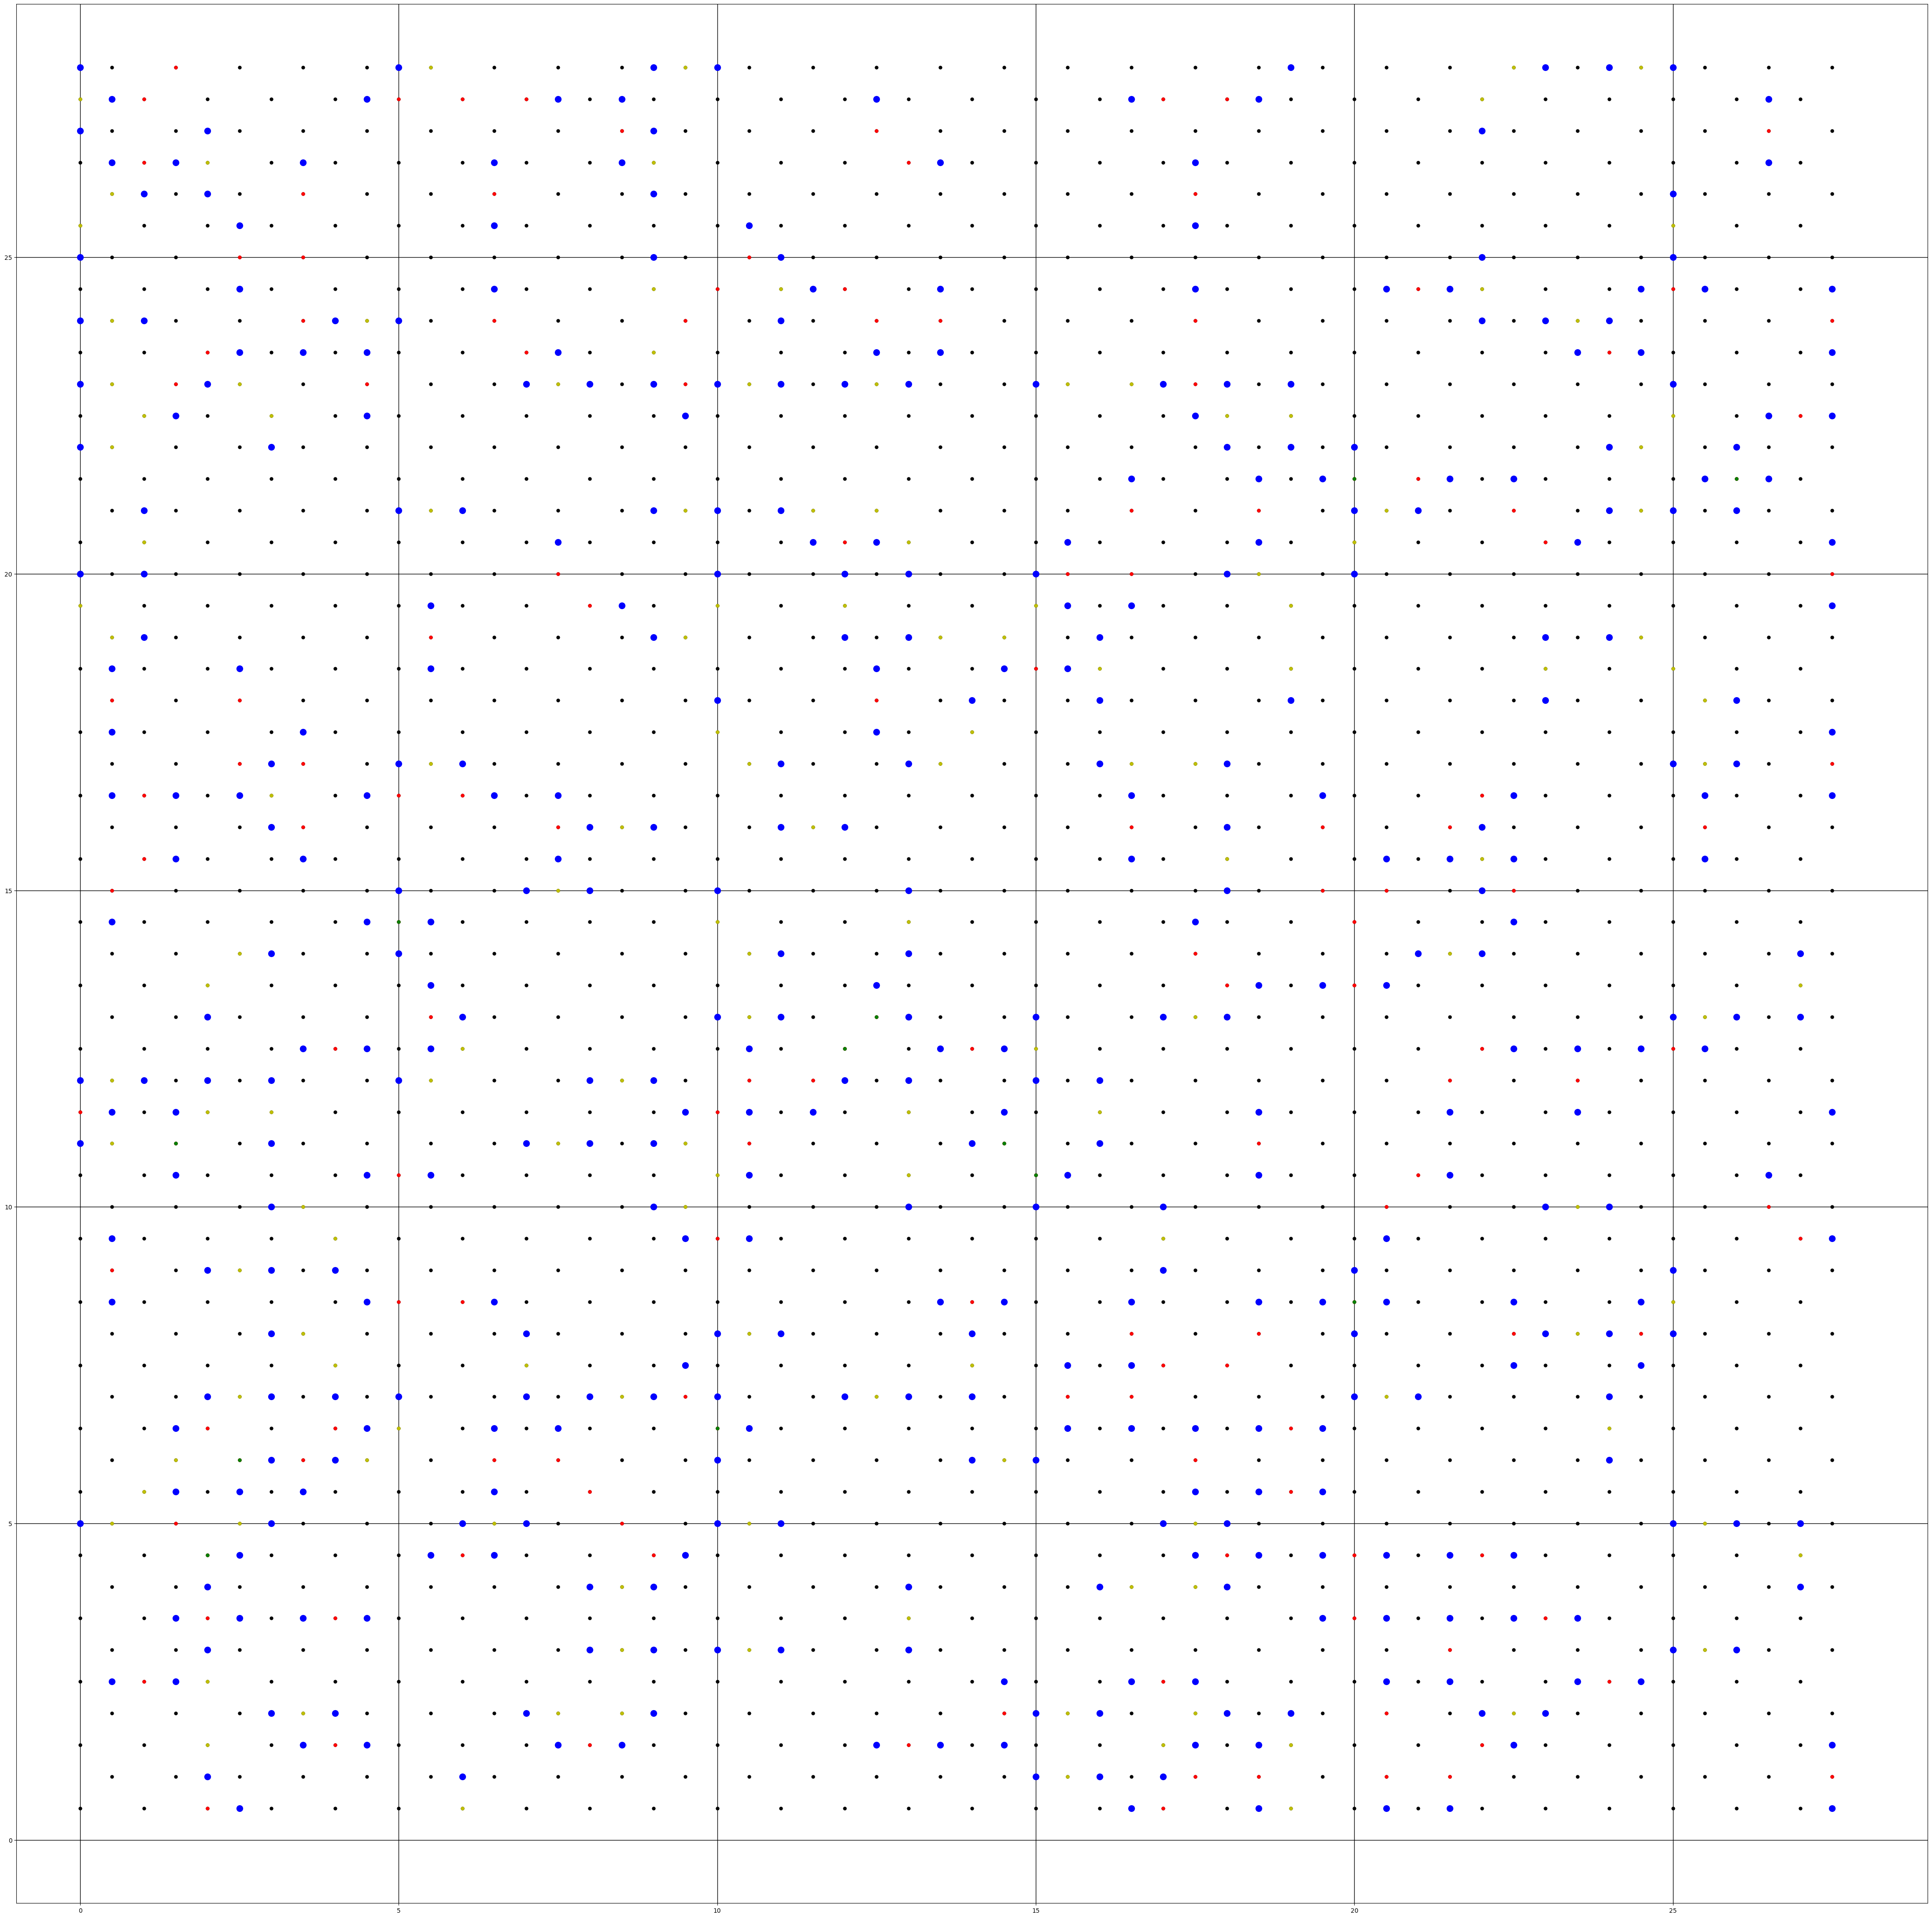

In [8]:

from Datavis import visualize_observation

visualize_observation(non_test[0])


We would like to have the patches to be of size 32x32 such that we can reduce it to 1x1 via 5x5 convolutions and max pooling layers. So, here we pad the images on the left and right with zeros.

In [9]:
train_data_2D = np.pad(train_data_2D,((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=((0,0),(0,0),(0,0),(0,0)))
eval_data_2D = np.pad(eval_data_2D,((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=((0,0),(0,0),(0,0),(0,0)))

non_test_data_2D = np.pad(non_test_data_2D,((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=((0,0),(0,0),(0,0),(0,0)))
test_data_2D = np.pad(test_data_2D,((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=((0,0),(0,0),(0,0),(0,0)))

print(train_data_2D.shape, eval_data_2D.shape)
print(non_test_data_2D.shape, test_data_2D.shape)

(60000, 32, 32, 1) (10000, 32, 32, 1)
(60000, 32, 60, 1) (10000, 32, 60, 1)


***
# Part 3: Build a graph (design the G-CNN)

## Build a graph

In [10]:
graph = tf.Graph()
graph.as_default()
tf.compat.v1.reset_default_graph()

## Settings

Kernel size and number of orientations

In [11]:
Ntheta = 4 # Kernel size in angular direction
Nxy=5       # Kernel size in spatial direction
Nc = 4      # Number of channels in the initial layer

### Placeholders

In [12]:
inputs_ph = tf.placeholder( dtype = tf.float32, shape = [None,32,60,1] ) # data shape here
labels_ph = tf.placeholder( dtype = tf.int32, shape = [None,4 * 28 **2] )

### Prepare for the first layer

In [13]:
tensor_in = inputs_ph
Nc_in = 1

### Save the kernels to a library for later inspection

In [14]:
kernels={}

## Layer 1: The lifting layer

In [15]:
with tf.variable_scope("Layer_{}".format(1)) as _scope:
    ## Settings
    Nc_out = Nc

    ## Perform lifting convolution
    # The kernels used in the lifting layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # Lifting layer
    tensor_out, kernels_formatted = se2cnn.layers.z2_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw,
                            orientations_nb = Ntheta)
    # Add bias
    tensor_out = tensor_out + bias
    
    ## Perform (spatial) max-pooling
    tensor_out = se2cnn.layers.spatial_max_pool( input_tensor=tensor_out, nbOrientations=Ntheta)
    
    ## Apply ReLU
    tensor_out = tf.nn.tanh(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

Z2-SE2N BASE KERNEL SHAPE: (5, 5, 1, 4)
Z2-SE2N ROTATED KERNEL SET SHAPE: (4, 5, 5, 1, 4)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 28, 56, 4, 4)


In [16]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(14), Dimension(28), Dimension(4), Dimension(4)])

## Layer 2: SE2-conv, max-pool, relu

In [17]:
with tf.variable_scope("Layer_{}".format(2)) as _scope:
    ## Settings
    Nc_out = 2*Nc

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Ntheta,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Ntheta*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # The group convolution layer
    tensor_out, kernels_formatted = se2cnn.layers.se2n_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw)
    tensor_out = tensor_out + bias
    
    ## Perform max-pooling
    tensor_out = se2cnn.layers.spatial_max_pool( input_tensor=tensor_out, nbOrientations=Ntheta)
    
    ## Apply ReLU
    tensor_out = tf.nn.tanh(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

SE2N-SE2N BASE KERNEL SHAPE: (5, 5, 4, 4, 8)
SE2N-SE2N ROTATED KERNEL SET SHAPE: (4, 5, 5, 4, 4, 8)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 10, 24, 4, 8)


In [18]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(5), Dimension(12), Dimension(4), Dimension(8)])

## Layer 3: 2D fully connected layer (5x5)

In [19]:
# Concatenate the orientation and channel dimension
tensor_in = tf.concat([tensor_in[:,:,:,i,:] for i in range(Ntheta)],3)
Nc_in = tensor_in.get_shape().as_list()[-1]

# 2D convolution layer
with tf.variable_scope("Layer_{}".format(3)) as _scope:
    ## Settings
    Nc_out = 4*Nc

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # Convolution layer
    tensor_out = tf.nn.conv2d(
                        input = tensor_in,
                        filter=kernels_raw,
                        strides=[1, 1, 1, 1],
                        padding="VALID")
    tensor_out = tensor_out + bias
    
    ## Apply ReLU
    tensor_out = tf.nn.tanh(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_raw

In [20]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(1), Dimension(8), Dimension(16)])

## Layer 4: Fully connected layer (1x1)

In [21]:
# 2D convolution layer
with tf.variable_scope("Layer_{}".format(4)) as _scope:
    ## Settings
    Nc_out = 128

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [1,1,Nc_in,Nc_out],
                        initializer=weight_initializer(1*1*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # Convolution layer
    tensor_out = tf.nn.conv2d(
                        input = tensor_in,
                        filter=kernels_raw,
                        strides=[1, 1, 1, 1],
                        padding="VALID")
    tensor_out = tensor_out + bias
    
    ## Apply ReLU
    tensor_out = tf.nn.tanh(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_raw

In [22]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(1), Dimension(8), Dimension(128)])

## Layer 5: Fully connected (1x1) to output

In [23]:
with tf.variable_scope("Layer_{}".format(5)) as _scope:
    ## Settings
    Nc_out = 4 * 28**2

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [1,1,Nc_in,Nc_out],
                        initializer=weight_initializer(1*1*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))

    
    ## Convolution layer
    tensor_out = tf.nn.conv2d(
                        input = tensor_in,
                        filter=kernels_raw,
                        strides=[1, 1, 1, 1],
                        padding="VALID")
    tensor_out = tensor_out + bias
    
    ## The output logits
    logits = tensor_out[:,0,0,:]
    print(logits.get_shape())
    predictions = logits
    print(predictions.get_shape())
    probabilities = tf.nn.softmax(logits)
    print(probabilities.get_shape())
    
    ## Save the kernels for later inspection
    kernels[_scope.name] = kernels_raw

(?, 3136)
(?, 3136)
(?, 3136)


In [24]:
logits.get_shape()

TensorShape([Dimension(None), Dimension(3136)])

## Define the loss and the optimizer

In [25]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

@tf.function
def macro_f1_loss(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [26]:
# Cross-entropy loss
loss = macro_f1_loss(y_hat=labels_ph, y = logits) #tf.losses.sparse_softmax_cross_entropy(labels=labels_ph, logits=logits)

In [27]:
#-- Define the l2 loss 
weightDecay=5e-4
# Get the raw kernels
variables_wd = tf.get_collection('raw_kernels')
print('-----')
print('RAW kernel shapes:')
for v in variables_wd: print( "[{}]: {}, total nr of weights = {}".format(v.name, v.get_shape(), size_of(v)))
print('-----')
loss_l2 = weightDecay*sum([tf.nn.l2_loss(ker) for ker in variables_wd])

-----
RAW kernel shapes:
[Layer_1/kernel:0]: (5, 5, 1, 4), total nr of weights = 100
[Layer_2/kernel:0]: (5, 5, 4, 4, 8), total nr of weights = 3200
[Layer_3/kernel:0]: (5, 5, 32, 16), total nr of weights = 12800
[Layer_4/kernel:0]: (1, 1, 16, 128), total nr of weights = 2048
[Layer_5/kernel:0]: (1, 1, 128, 3136), total nr of weights = 401408
-----


In [28]:
# Configure the Training Op (for TRAIN mode)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(
    loss=loss + loss_l2,
    global_step=tf.train.get_global_step())


***
# Part 4: Train and test the G-CNN

## Begin session

In [29]:
#-- Start the (GPU) session
initializer = tf.global_variables_initializer()
session = tf.Session(graph=tf.get_default_graph()) #-- Session created
session.run(initializer)

## Optimization

In each epoch we pass over all input samples in batch sizes of batch_size

In [30]:
batch_size=100
n_epochs=10

Loop over the input stack in batch of size "batch_size".

In [31]:
print(f"single size: {train_labels.shape}, multi size: {non_test_labels.shape}")

single size: (60000,), multi size: (60000, 3136)


In [32]:
for epoch_nr in range(n_epochs):
    loss_average = 0
    data = non_test_data_2D
    labels = non_test_labels
    # KBatch settings
    NItPerEpoch = m.floor(len(data)/batch_size) #number of iterations per epoch
    samples=np.random.permutation(len(data))
    # Loop over dataset
    tStart = time.time()
    for iteration in range(NItPerEpoch):
        feed_dict = {
                inputs_ph: np.array(data[samples[iteration*batch_size:(iteration+1)*batch_size]]),
                labels_ph: np.array(labels[samples[iteration*batch_size:(iteration+1)*batch_size]])
                }
        operators_output = session.run([ loss , train_op ], feed_dict)
        loss_average += operators_output[0]/NItPerEpoch
    tElapsed = time.time() - tStart
    print('Epoch ' , epoch_nr , ' finished... Average loss = ' , round(loss_average,4) , ', time = ',round(tElapsed,4))

Epoch  0  finished... Average loss =  0.8231 , time =  6.6429
Epoch  1  finished... Average loss =  0.8205 , time =  4.2606
Epoch  2  finished... Average loss =  0.8191 , time =  4.2195
Epoch  3  finished... Average loss =  0.8181 , time =  4.2153
Epoch  4  finished... Average loss =  0.8172 , time =  4.1946
Epoch  5  finished... Average loss =  0.8163 , time =  4.1913
Epoch  6  finished... Average loss =  0.8155 , time =  4.1574
Epoch  7  finished... Average loss =  0.8147 , time =  4.2788
Epoch  8  finished... Average loss =  0.814 , time =  4.2337
Epoch  9  finished... Average loss =  0.8134 , time =  3.842


## Validation

In [33]:
batch_size = 1000
labels_pred = []
for i in range(round(len(test_data_2D)/batch_size)): # Loop over batches
    [ labels_pred_batch ] = session.run([ predictions ], { inputs_ph: test_data_2D[i*batch_size:(i+1)*batch_size] })
    labels_pred = labels_pred + list(labels_pred_batch)
labels_pred = np.array(labels_pred)

Compare the first 10 results with the ground truth

In [40]:
print(labels_pred[0:10])
# print highest and lowest prediction
labels_pred = labels_pred.round()
print(np.max(labels_pred)) 
print(np.min(labels_pred))

print(test_labels[0:10])

[[1. 1. 3. ... 3. 1. 1.]
 [1. 1. 3. ... 3. 1. 1.]
 [1. 1. 3. ... 3. 1. 1.]
 ...
 [1. 1. 3. ... 3. 1. 1.]
 [1. 1. 3. ... 3. 1. 1.]
 [1. 1. 3. ... 3. 1. 1.]]
4.0
-2.0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 1]]


The accuracy (average nr of successes)

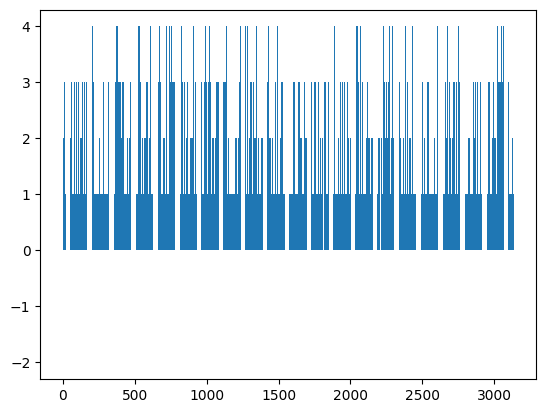

In [41]:
# bar plot of the prediction
obs = labels_pred[0]
plt.bar(np.arange(len(obs)), obs)
plt.show()



In [35]:
((labels_pred - eval_labels)**2==0).astype(float).mean()

ValueError: operands could not be broadcast together with shapes (10000,3136) (10000,) 

Total nr of errors

In [ ]:
((labels_pred - eval_labels)**2>0).astype(float).sum()

Error rate

In [ ]:
100*((labels_pred - eval_labels)**2>0).astype(float).mean()